In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import matplotlib.pyplot as plt
from models import create_model 
import pandas as pd

import yaml
import torch
from pipeline.walkforward import WFCVGenerator
from utils.paths import CONFIG_DIR, EXPERIMENTS_DIR, DATA_DIR

from config.config_types import AppConfig


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import json

fold = 0
name = "exp_008_mlp_linreg"
#name = "exp_009_mlp_nonlinreg"
#name = "exp_010_mlp_60_windows"
base = f"{EXPERIMENTS_DIR}/{name}/trial_20251020_024833/fold_{fold:03d}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg = AppConfig.from_dict(cfg)

if cfg.data["df_master"] is not None:
    df_master_path =  cfg.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None

wf = WFCVGenerator(config=cfg.walkforward)


In [28]:

test_data = {}
data = {}

for i, fold_data in enumerate(wf.folds(df_master)):
    if i <= 0:
        X_test = fold_data[4]
        y_test = fold_data[5]

        test_data[i] = [X_test, y_test]
        data[i] = fold_data
    else:
        break



In [33]:


hparams = cfg.model.hparams
input_shape = (cfg.walkforward.lags,)
ckpt_path = f"{base}model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")


/tmp/ipykernel_142419/1112722255.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cuda")


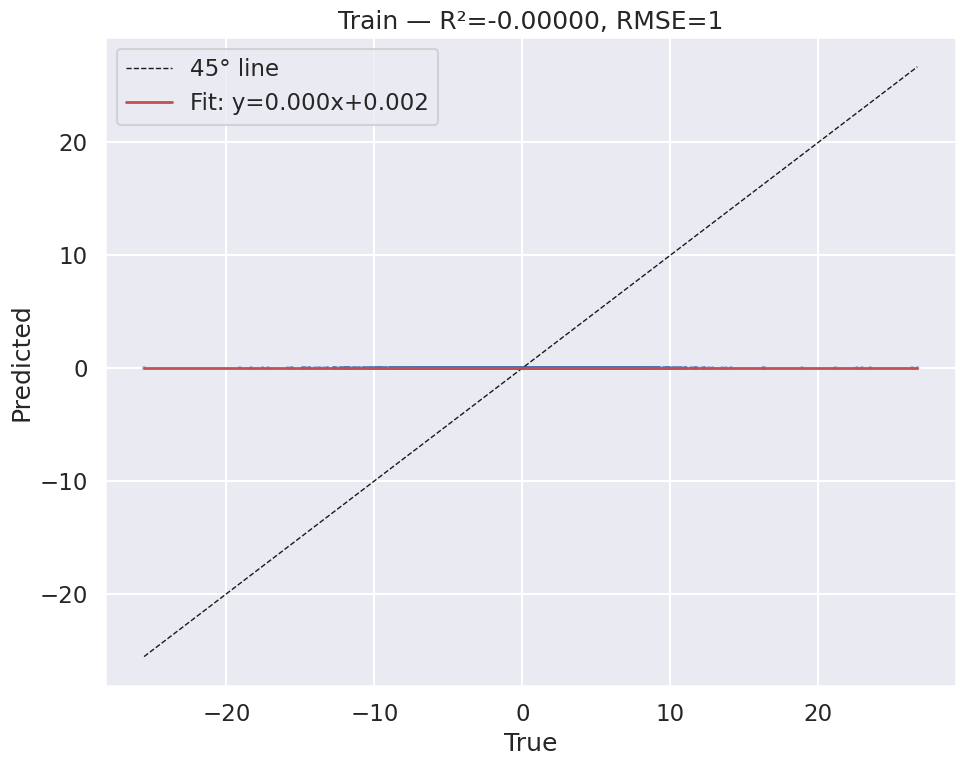

/tmp/ipykernel_142419/1838588894.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y_pred, fill=True, alpha=0.5, label="Predicted", linewidth=2)


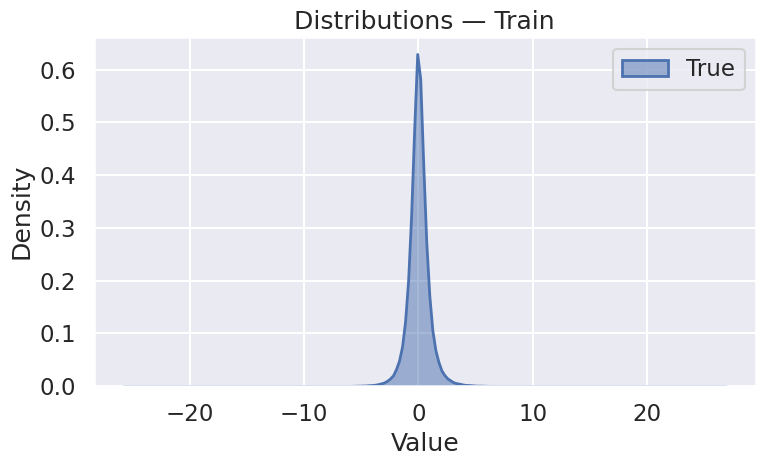

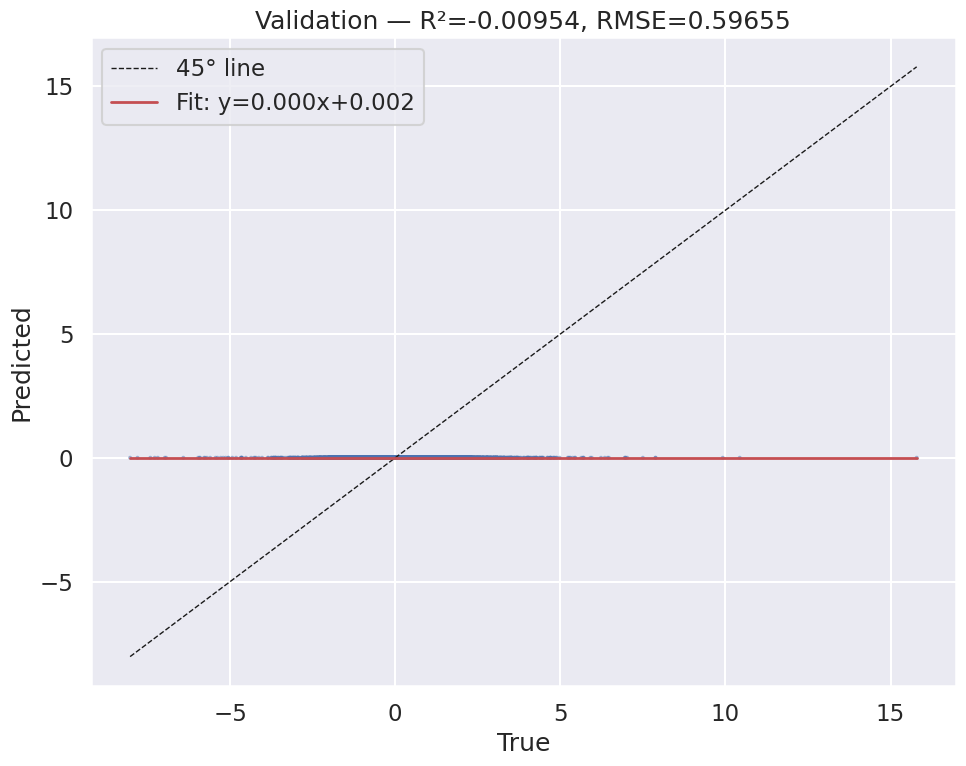

/tmp/ipykernel_142419/1838588894.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y_pred, fill=True, alpha=0.5, label="Predicted", linewidth=2)


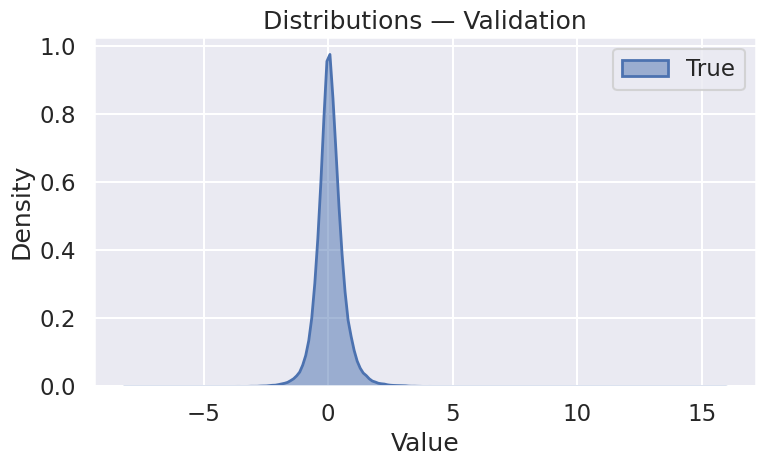

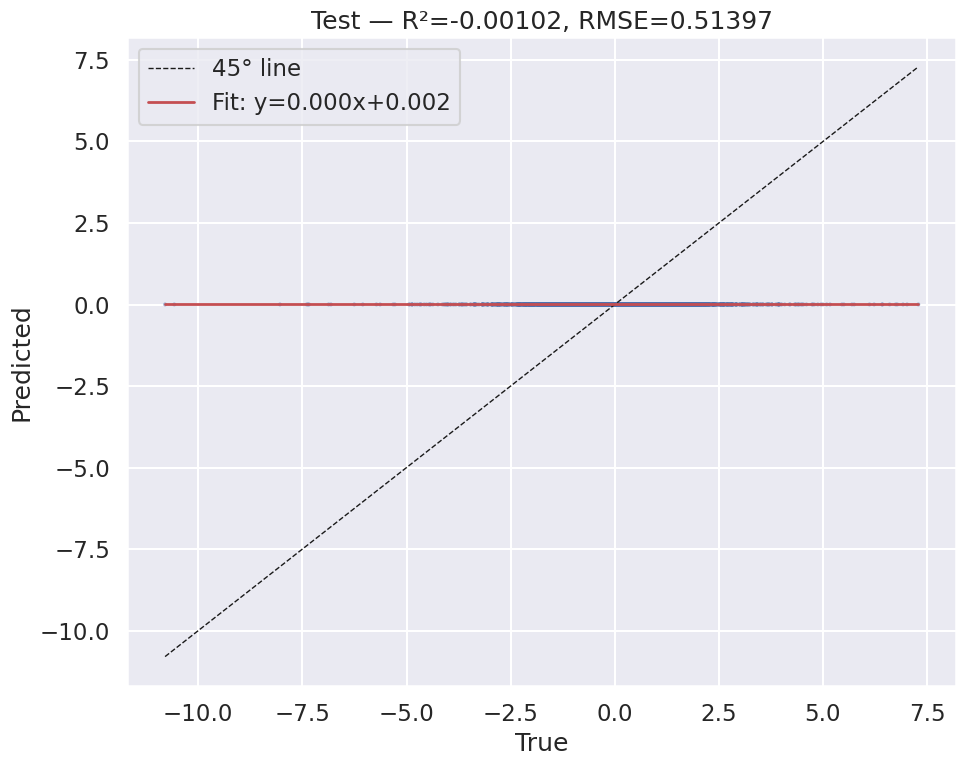

/tmp/ipykernel_142419/1838588894.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y_pred, fill=True, alpha=0.5, label="Predicted", linewidth=2)


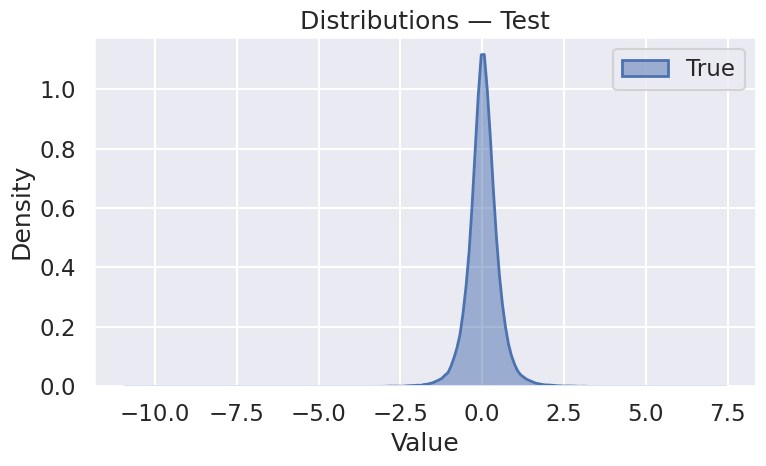

(MLPRegressor(
   (net): Sequential(
     (0): Linear(in_features=60, out_features=512, bias=True)
     (1): ReLU()
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=256, bias=True)
     (5): ReLU()
     (6): Linear(in_features=256, out_features=128, bias=True)
     (7): ReLU()
     (8): Linear(in_features=128, out_features=1, bias=True)
   )
 ),
 (array([-1.0469956 , -1.4115729 ,  0.82402915, ...,  1.4345491 ,
          1.5076567 ,  0.79119676], shape=(340268,), dtype=float32),
  array([0.00199289, 0.00199289, 0.00199289, ..., 0.00199289, 0.00199289,
         0.00199289], shape=(340268,), dtype=float32)),
 (array([ 0.91748434, -0.24932517,  0.17044295, ...,  0.10558853,
          0.18892992,  0.18895993], shape=(95031,), dtype=float32),
  array([0.00199289, 0.00199289, 0.00199289, ..., 0.00199289, 0.00199289,
         0.00199289], shape=(95031,), dtype=float32)),
 (array([-0.00311242, -0.00311242, -0.13354155

In [35]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme(style="darkgrid", context="talk")

def maybe_inverse(y, scaler):
    return y if scaler is None else scaler.inverse_transform(y.reshape(-1,1)).ravel()

def plot_split(title, y_true, y_pred):
    # linear fit + metrics
    reg = LinearRegression().fit(y_true.reshape(-1,1), y_pred)
    slope, intercept = reg.coef_[0], reg.intercept_
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    x_line = np.linspace(y_true.min(), y_true.max(), 200)
    y_line = reg.predict(x_line.reshape(-1,1))

    # 1) scatter
    plt.figure(figsize=(10,8))
    plt.scatter(y_true, y_pred, s=8, alpha=0.5, edgecolors="none")
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, 'k--', lw=1, label="45° line")
    plt.plot(x_line, y_line, 'r-', lw=2, label=f'Fit: y={slope:.3f}x+{intercept:.3f}')
    plt.title(f"{title} — R²={r2:.5f}, RMSE={rmse:.5g}")
    plt.xlabel("True"); plt.ylabel("Predicted"); plt.legend(); plt.tight_layout(); plt.show()

    # 2) KDEs
    plt.figure(figsize=(8,5))
    sns.kdeplot(y_true, fill=True, alpha=0.5, label="True", linewidth=2)
    sns.kdeplot(y_pred, fill=True, alpha=0.5, label="Predicted", linewidth=2)
    plt.title(f"Distributions — {title}")
    plt.xlabel("Value"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()

def eval_and_plot_simple(cfg, input_shape, ckpt, datasets, device="cuda"):
    Xtr, ytr, Xv, yv, Xte, yte = datasets

    # rebuild & load model
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in ckpt["model_state"].items()}
    model = create_model(cfg.model, input_shape)
    model.load_state_dict(state_dict)
    model.to(device).eval()

    # full-batch predictions (simple & fine for ~seconds runtime)
    with torch.no_grad():
        yhat_tr = model(torch.as_tensor(Xtr, dtype=torch.float32, device=device)).squeeze(-1).cpu().numpy()
        yhat_v  = model(torch.as_tensor(Xv,  dtype=torch.float32, device=device)).squeeze(-1).cpu().numpy()
        yhat_te = model(torch.as_tensor(Xte, dtype=torch.float32, device=device)).squeeze(-1).cpu().numpy()

    # true arrays (on CPU numpy)
    ytr = np.asarray(ytr, dtype=np.float32)
    yv  = np.asarray(yv,  dtype=np.float32)
    yte = np.asarray(yte, dtype=np.float32)


    # plots
    plot_split("Train",      ytr, yhat_tr)
    plot_split("Validation", yv,  yhat_v)
    plot_split("Test",       yte, yhat_te)

    return model, (ytr, yhat_tr), (yv, yhat_v), (yte, yhat_te)

eval_and_plot_simple(cfg, input_shape, checkpoint, data[fold])


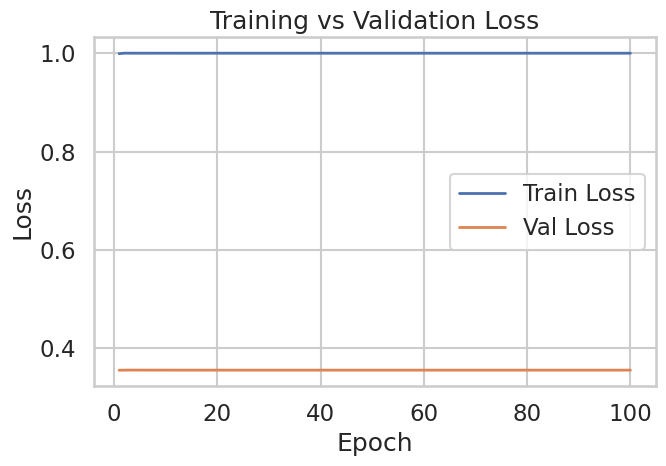

In [36]:
def plot_training_history(ckpt):
    """Plot train vs validation loss curves from the saved checkpoint."""
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return

    # Convert list of dicts to separate arrays
    tr_losses = [h["tr_loss"] for h in history]
    val_losses = [h["val_loss"] for h in history]
    epochs = np.arange(1, len(tr_losses) + 1)

    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_losses, label="Train Loss", lw=2)
    plt.plot(epochs, val_losses, label="Val Loss", lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(checkpoint)

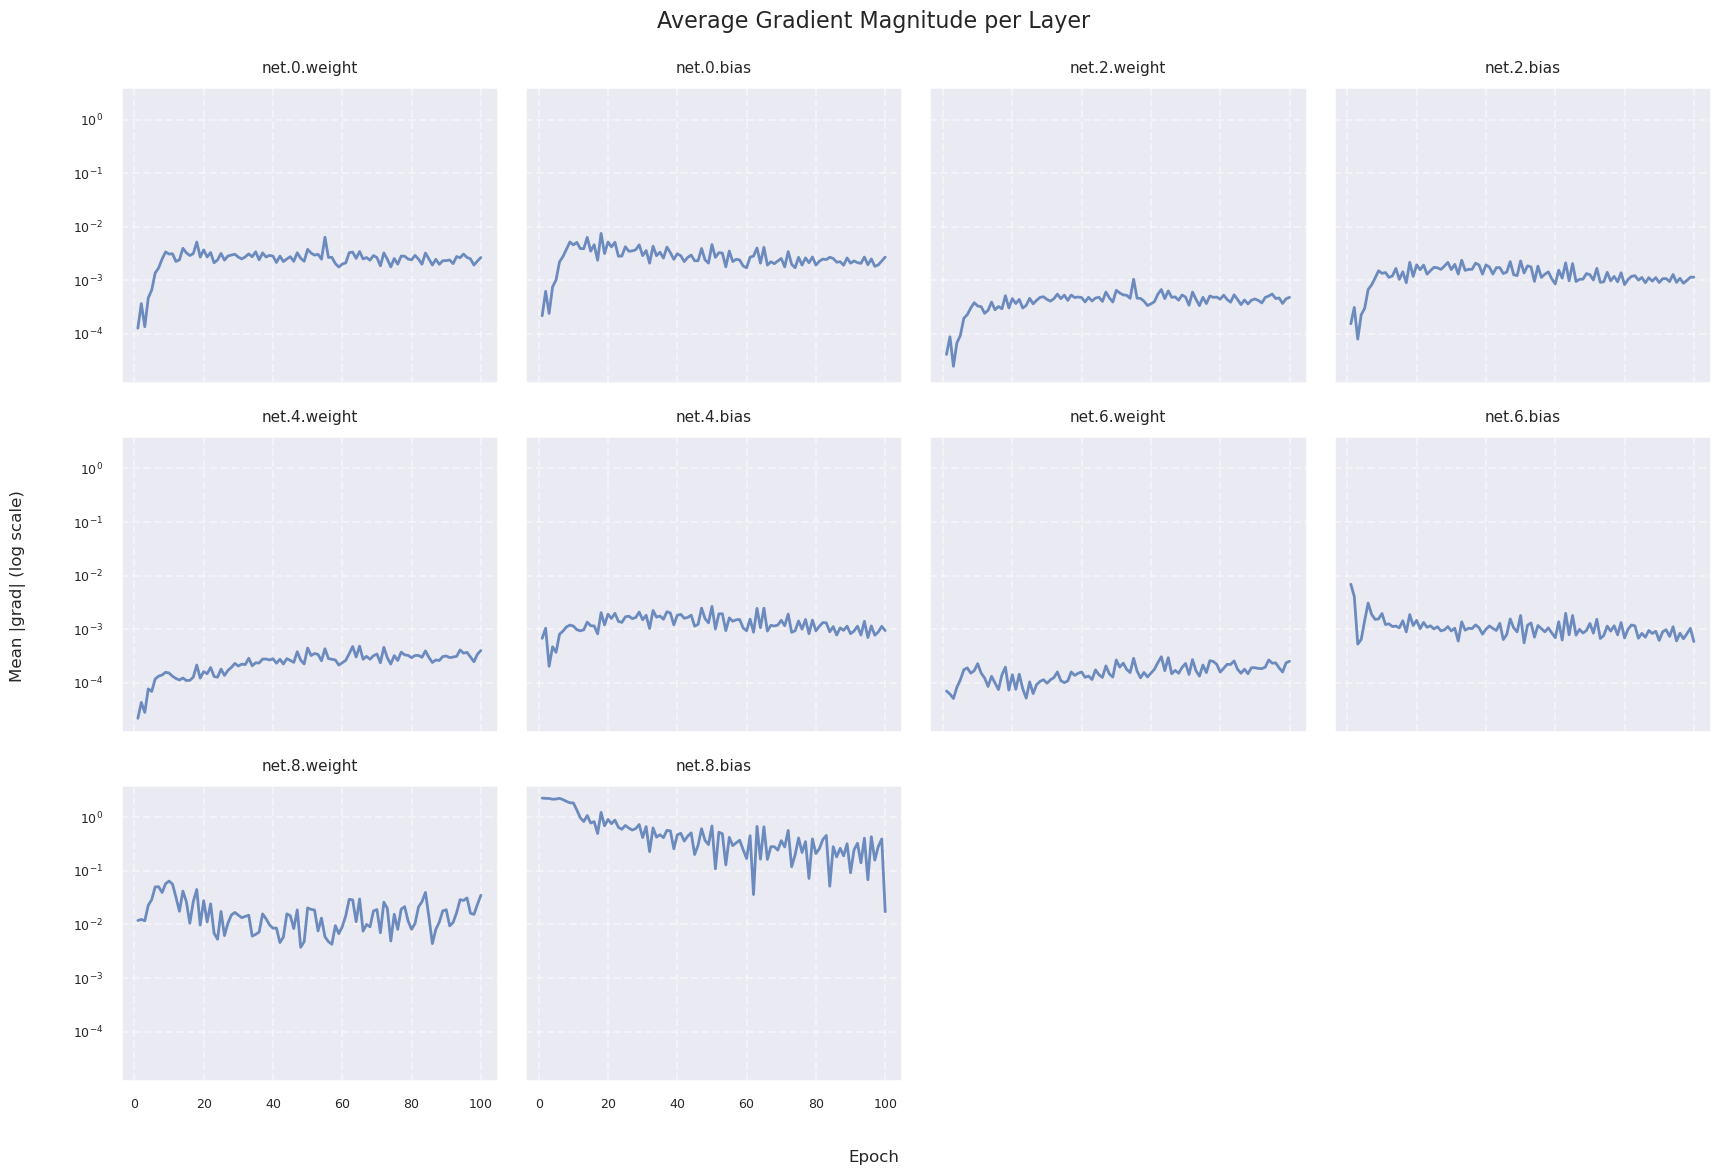

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_grad(ckpt):
    grad_history = ckpt.get("grad_history", [])
    if not grad_history:
        print("No grad_history found in checkpoint.")
        return

    df = pd.DataFrame(grad_history)
    if "epoch" not in df.columns:
        print("No 'epoch' column found in grad_history.")
        return

    df.set_index("epoch", inplace=True)
    
    # Clean column names for display (remove prefixes like _orig_mod.)
    df.columns = [c.replace("_orig_mod.", "") for c in df.columns]

    # --- grid setup ---
    n_cols = 4
    n_layers = len(df.columns)
    n_rows = math.ceil(n_layers / n_cols)

    # Increase figure size and adjust spacing
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], lw=2, alpha=0.8)
        ax.set_title(col, fontsize=11, pad=10)
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Improve tick label formatting
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis='both', which='minor', labelsize=7)
    
    # Hide empty tiles if #layers < grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout with more padding
    plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.96])  # [left, bottom, right, top]
    
    # Add titles with proper positioning
    fig.suptitle("Average Gradient Magnitude per Layer", fontsize=16, y=0.98)
    fig.text(0.5, 0.02, "Epoch", ha="center", fontsize=12)
    fig.text(0.02, 0.5, "Mean |grad| (log scale)", va="center", rotation="vertical", fontsize=12)
    
    plt.show()

plot_grad(checkpoint)

In [12]:
ckpt = checkpoint
grad_history = ckpt.get("grad_history", [])

df = pd.DataFrame(grad_history)

df.set_index("epoch", inplace=True)

# Clean column names for display (remove prefixes like _orig_mod.)
df.columns = [c.replace("_orig_mod.", "") for c in df.columns]
df


,net.0.weight,net.0.bias,net.2.weight,net.2.bias,net.4.weight,net.4.bias,net.6.weight,net.6.bias,net.8.weight,net.8.bias
epoch,,,,,,,,,,
1,2.166352e-09,1.011353e-07,3.667628e-09,1.238500e-07,3.238931e-09,3.186378e-07,3.597742e-08,0.000984,0.000782,0.079045
2,3.396745e-10,5.057931e-09,3.256334e-10,7.991417e-09,1.486913e-10,1.350418e-08,4.987494e-11,0.000736,0.000576,0.079600
3,3.557912e-08,1.789341e-06,3.496500e-08,1.835768e-06,4.487552e-08,6.111364e-06,1.016041e-07,0.000533,0.000443,0.080421
4,1.259743e-08,6.322344e-07,1.458833e-08,8.853553e-07,2.491114e-08,4.723522e-06,1.102999e-07,0.000378,0.000333,0.080485
5,3.948898e-09,1.927032e-07,4.955769e-09,3.144621e-07,5.456241e-09,1.138449e-06,2.279523e-08,0.000308,0.000278,0.080378
...,...,...,...,...,...,...,...,...,...,...
96,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.074379
97,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.074379
98,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.074379


In [8]:
x_tr = data[0][0]
y_tr = data[0][1]
print(np.mean(x_tr))
print(np.mean(y_tr))

0.00011338940795775483
0.00015514361230578382


In [8]:
np.unique(y_pred)

array([0.00953834], dtype=float32)

In [10]:
print(f"y_true range: [{y_true.min():.4f}, {y_true.max():.4f}], std: {y_true.std():.4f}")
print(f"y_pred range: [{y_pred.min():.4f}, {y_pred.max():.4f}], std: {y_pred.std():.4f}")

y_true range: [-0.5206, 0.3640], std: 0.0163
y_pred range: [0.0014, 0.0014], std: 0.0000


In [11]:
# Print some model weights to verify they're not all zeros/same
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean():.6f}, std={param.std():.6f}")
    #break  # just check first layer

net.0.weight: mean=-0.000000, std=0.000006
net.0.bias: mean=-0.054841, std=0.070977
net.3.weight: mean=0.000000, std=0.000005
net.3.bias: mean=0.001408, std=nan


/tmp/ipykernel_3176077/2507637824.py:3: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  print(f"{name}: mean={param.mean():.6f}, std={param.std():.6f}")


In [12]:
print(f"X shape: {X.shape}")
print(f"X range: [{X.min():.6f}, {X.max():.6f}]")
print(f"X std: {X.std():.6f}")
print(f"Any NaN in X? {torch.isnan(X).any()}")

X shape: torch.Size([114914, 20])
X range: [-0.520635, 0.364016]
X std: 0.016375
Any NaN in X? False


In [13]:
print(f"Model training mode: {model.training}")  # Should be False

Model training mode: False
